In [1]:
from hazma.gamma_ray_parameters import comptel_diffuse

In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import h5py

from hazma import decay
import utils
from utils import MK0, MPI, MPI0, MMU, ME, MOMEGA
from utils import ThreeBodyPhaseSpace

from hazma.decay import charged_pion as dnde_cp
from hazma.decay import neutral_pion as dnde_np
from hazma.decay import muon as dnde_mu

In [2]:
# BR(π⁺, π⁻, π⁰) = 89.2 ± 0.7 %
BR_OMEGA_TO_PI_PI_PI0 = 89.2e-2
# BR(π⁰, γ) = 8.34 ± 0.26 %
BR_OMEGA_TO_PI0_A = 8.34e-2
# BR(π⁺, π⁻) = 1.53 +0.11 −0.13 %
BR_OMEGA_TO_PI_PI = 1.53e-2

# BR(η, γ) = 4.5e-4 ± 0.4e-4 
BR_OMEGA_TO_ETA_A = 4.5e-4 
# BR(π⁰, e⁺, e⁻) = 7.7e-4 ± 0.6e-4 
BR_OMEGA_TO_PI0_E_E = 7.7e-4 
# BR(π⁰, μ⁺, μ⁻) = 1.34e-4 ± 0.18e-4
BR_OMEGA_TO_PI0_MU_MU = 1.34e-4 
# BR(e⁺, e⁻) = 7.39e-5 ± 0.19e-5
BR_OMEGA_TO_E_E = 7.39e-5 
# BR(μ⁺, μ⁻) = 7.4e-5 ± 1.8e-5 
BR_OMEGA_TO_MU_MU = 7.4e-5 
# BR(π⁰, π⁰, γ) = 6.7e-5 ± 1.1e-5 
BR_OMEGA_TO_PI0_PI0_A = 6.7e-5 

In [6]:
# Not sure what the matrix element is

def msqrd(s, t):
    return 1.0

tbps = ThreeBodyPhaseSpace(MOMEGA, MPI0, MPI, MPI, msqrd)
omega_to_pi0_pi_pi_edists = tbps.energy_distributions(25, maxiter=1000)
omega_to_pi0_pi_pi_s_dist = tbps.invariant_mass_distribution(1, 2, 25, maxiter=1000)
omega_to_pi0_pi_pi_t_dist = tbps.invariant_mass_distribution(0, 2, 25, maxiter=1000)
omega_to_pi0_pi_pi_u_dist = tbps.invariant_mass_distribution(0, 1, 25, maxiter=1000)

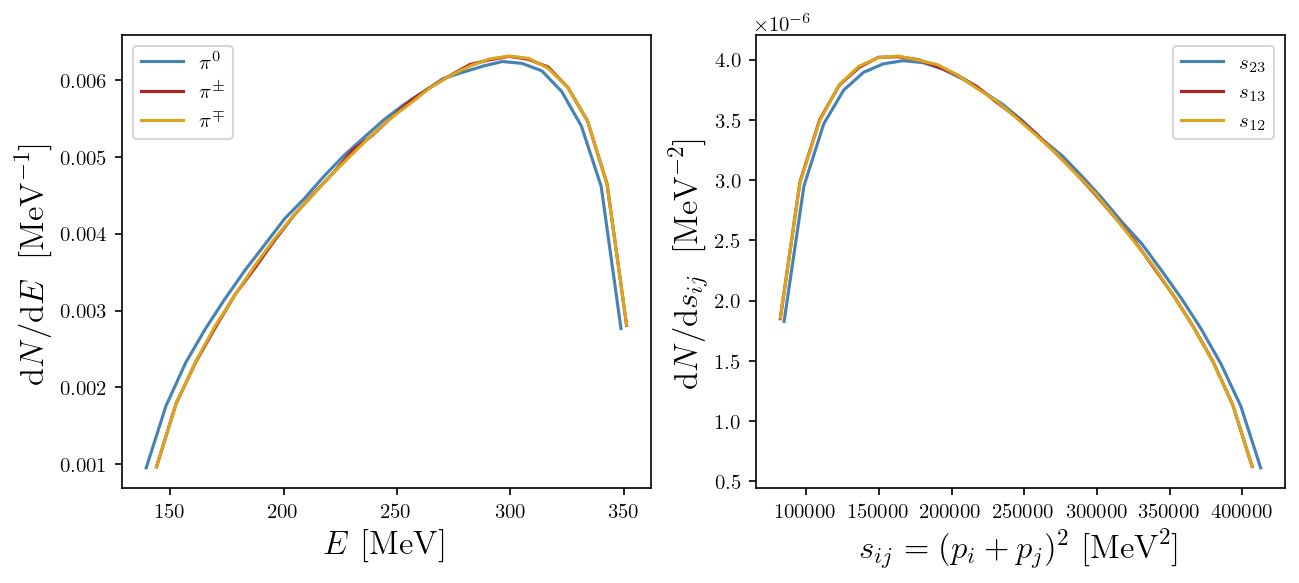

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,4))

labels = [r"$\pi^{0}$", r"$\pi^{\pm}$", r"$\pi^{\mp}$"]
for (cs, ps), label in zip(omega_to_pi0_pi_pi_edists, labels):
    axes[0].plot(cs, ps, label=label)

axes[0].legend()
axes[0].set_ylabel(r"$\dv*{N}{E} \ [\mathrm{MeV}^{-1}]$", fontdict={'size': 16})
axes[0].set_xlabel(r"$E \ [\mathrm{MeV}]$", fontdict={'size': 16})

labels = [r"$s_{23}$", r"$s_{13}$", r"$s_{12}$"]
dists = [omega_to_pi0_pi_pi_s_dist, omega_to_pi0_pi_pi_t_dist, omega_to_pi0_pi_pi_u_dist]
for (cs, ps), label in zip(dists, labels):
    axes[1].plot(cs, ps, label=label)

axes[1].set_ylabel(r"$\dv*{N}{s_{ij}} \ [\mathrm{MeV}^{-2}]$", fontdict={'size': 16})
axes[1].set_xlabel(r"$s_{ij} = (p_{i} + p_{j})^{2} \ [\mathrm{MeV}^{2}]$", fontdict={'size': 16})
axes[1].legend()

In [12]:
with h5py.File(Path(os.getcwd()).joinpath("data").joinpath("omega_decay_data.hdf5"), "w") as f:
    # omega -> pi0 + pi + pi
    root = f.create_group("/pi0_pi_pi")
    grp = root.create_group("energy_distributions")
    d1, d2, d3 = omega_to_pi0_pi_pi_edists
    sdist = omega_to_pi0_pi_pi_s_dist
    tdist = omega_to_pi0_pi_pi_t_dist
    udist = omega_to_pi0_pi_pi_u_dist

    grp.create_dataset("energies", data=np.vstack((d1[0], d2[0], d3[0])))
    grp.create_dataset("probabilities", data=np.vstack((d1[1], d2[1], d3[1])))

    grp = root.create_group("invariant_mass_distributions/s")
    grp.create_dataset("invariant_masses", data=sdist[0])
    grp.create_dataset("probabilities", data=sdist[1])

    grp = root.create_group("invariant_mass_distributions/t")
    grp.create_dataset("invariant_masses", data=tdist[0])
    grp.create_dataset("probabilities", data=tdist[1])
    
    grp = root.create_group("invariant_mass_distributions/u")
    grp.create_dataset("invariant_masses", data=udist[0])
    grp.create_dataset("probabilities", data=udist[1])

In [3]:
class OmegaSpectra:

    def __init__(self):
        file = Path(os.getcwd()).joinpath("data").joinpath("omega_decay_data.hdf5")
        with h5py.File(file, "r") as f:
            self._edists = {
                "pi0 pi pi": {
                    "e": f["/pi0_pi_pi/energy_distributions/energies"][:],
                    "dnde": f["/pi0_pi_pi/energy_distributions/probabilities"][:],
                },
            }
            self._invariant_mass_dists = {
                "pi0 pi pi": {
                    "s":    f["/pi0_pi_pi/invariant_mass_distributions/s/invariant_masses"][:],
                    "t":    f["/pi0_pi_pi/invariant_mass_distributions/t/invariant_masses"][:],
                    "u":    f["/pi0_pi_pi/invariant_mass_distributions/u/invariant_masses"][:],
                    "dnds": f["/pi0_pi_pi/invariant_mass_distributions/s/probabilities"][:],
                    "dndt": f["/pi0_pi_pi/invariant_mass_distributions/t/probabilities"][:],
                    "dndu": f["/pi0_pi_pi/invariant_mass_distributions/u/probabilities"][:],
                },
            }
    
    def dnde_photon_pi0_a(self, e):
        epi = utils.energy_one_cme(MOMEGA, MPI0, 0)
        return dnde_np(e, epi)

    def dnde_photon_pi_pi(self, e):
        res = np.zeros_like(e)
        epi = utils.energy_one_cme(MOMEGA, MPI, MPI)
        res += 2 * dnde_cp(e, epi)
        res += 2 * utils.dnde_photon_fsr_scalar(e, MOMEGA**2, MPI, q=1.0)
        return res

    def dnde_photon_pi0_pi_pi(self, e):
        key = "pi0 pi pi"

        res = np.zeros_like(e)
        dists = self._edists[key]
        res += utils.convolve(e, dnde_np, dists["e"][0], dists["dnde"][0])
        res += utils.convolve(e, dnde_cp, dists["e"][1], dists["dnde"][1])
        res += utils.convolve(e, dnde_cp, dists["e"][2], dists["dnde"][2])

        # Average FSR over s, t and u channels 
        fsr = lambda x, y: utils.dnde_photon_fsr_scalar(x, y, MPI, q=1.0)
        inv_dist = self._invariant_mass_dists[key]
        res += 0.5 * utils.convolve(e, fsr, inv_dist["s"], inv_dist["dnds"])
        res += 0.5 * utils.convolve(e, fsr, inv_dist["t"], inv_dist["dndt"])
        res += 0.5 * utils.convolve(e, fsr, inv_dist["u"], inv_dist["dndu"])

        return res


    def dnde_photon(self, e, components=False):
        pi0_pi_pi = BR_OMEGA_TO_PI_PI_PI0 * self.dnde_photon_pi0_pi_pi(e)
        pi_pi = BR_OMEGA_TO_PI_PI * self.dnde_photon_pi_pi(e)
        pi0_a = BR_OMEGA_TO_PI0_A * self.dnde_photon_pi0_a(e)

        if components:
            return {
                "pi0 pi pi": pi0_pi_pi,
                "pi pi": pi_pi,
                "pi0 a": pi0_a,
            }
        return pi0_pi_pi + pi0_a + pi_pi

/home/logan/github/Hazma/hazma/decay.py:208: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.charged_pion_decay_spectrum(
/home/logan/github/Hazma/notebooks/decay_spectra/utils.py:63: RuntimeWarning: invalid value encountered in log
  np.e * m ** 2 / s > xm, 0.0, 2.0 * xm / x * (np.log(s * xm / m ** 2) - 1.0)


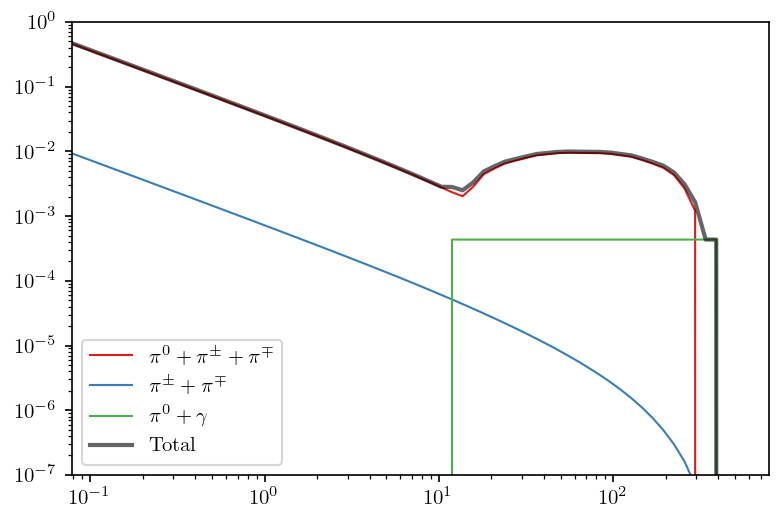

In [4]:
labels = {
    "pi0 pi pi" : r"$\pi^{0} + \pi^{\pm} + \pi^{\mp}$",
    "pi pi" : r"$\pi^{\pm} + \pi^{\mp}$",
    "pi0 a" : r"$\pi^{0} + \gamma$",
    "total": r"$\mathrm{Total}$"
}

plot_params = {
    "pi0 pi pi" : {"c": utils.qualitative[0], "lw": 1},
    "pi pi" : {"c": utils.qualitative[1], "lw": 1},
    "pi0 a" : {"c": utils.qualitative[2], "lw": 1},
    "total": {"c": "k", "lw": 2, "alpha": 0.6},
}

es = MOMEGA * np.geomspace(1e-6, 1.0, 100)
dnde_omega = OmegaSpectra().dnde_photon(es, components=True)

plt.figure(dpi=150)

for key, val in dnde_omega.items():
    plt.plot(es, val, label=labels[key], **plot_params[key])
plt.plot(es, sum(dnde_omega.values()), label=labels["total"], **plot_params["total"])

plt.ylim(1e-7, 1e0)
plt.xlim(np.max(es) * 1e-4, np.max(es))
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [5]:
es = MOMEGA * np.geomspace(1e-6, 1.0, 500)
dnde_omega = sum(OmegaSpectra().dnde_photon(es, components=True).values())

s = slice(0, np.argwhere(dnde_omega <= 0)[0,0])
data = np.array([es[s], dnde_omega[s]]).T

np.savetxt(Path(os.getcwd()).joinpath("data").joinpath("omega_dnde_photon.csv"), data, delimiter=",", header="energy, dnde")

/home/logan/github/Hazma/hazma/decay.py:208: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.charged_pion_decay_spectrum(
/home/logan/github/Hazma/notebooks/decay_spectra/utils.py:63: RuntimeWarning: invalid value encountered in log
  np.e * m ** 2 / s > xm, 0.0, 2.0 * xm / x * (np.log(s * xm / m ** 2) - 1.0)
